In [ ]:
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split as tr_te_split

from sklearn.linear_model import LogisticRegression as LogitReg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  roc_curve, auc, plot_roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def printCM(tn, fp, fn, tp):
    print('{: <9} {: <9} {: <9}'.format(' ',' ','predicted'))
    print('         --------------------')
    print('{: <9}|{: <9d}|{: <9d}'.format('Actual',0,1))
    print('-----------------------------')
    print('{: <9d}|tn={: <6d}|fp={: <9d}'.format(0,tn,fp))
    print('-----------------------------')
    print('{: <9d}|fn={: <6d}|tp={: <9d}'.format(1,fn,tp))

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
downloaded = drive.CreateFile({'id':'174AbMaoCsy7Ko25aylK7_Q7A3gY8Tq1N'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dataframe_train.csv') 

#3. Read file as panda dataframe
df_train = pd.read_csv("dataframe_train.csv")
df_train

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_type,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour
0,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,120,ASSIGN,2.100070e+18,121.630997,39.142343,121.632547,39.141946,377.0,804,1246,11
1,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,121,PICKUP,2.100070e+18,121.632547,39.141946,121.626144,39.140281,780.0,298,1246,11
2,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,122,DELIVERY,2.100070e+18,121.626144,39.140281,121.631219,39.141811,550.0,545,2462,11
3,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,123,PICKUP,2.100070e+18,121.631219,39.141811,121.632084,39.146201,707.0,341,1205,11
4,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,753c1911e8a294c5db901f8555faff0c,92ec52685bd511da262ee6f7a0adaa87,124,DELIVERY,2.100070e+18,121.632084,39.146201,121.631574,39.142231,770.0,166,1882,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509599,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,69cf59a0ef0132f2b615b93891186598,c7fe31139b02bf53003cd9a8d71d4936,509599,DELIVERY,2.100080e+18,121.445284,39.211421,121.444934,39.211511,1.0,2,2300,12
509600,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509600,DELIVERY,2.100080e+18,121.444934,39.211511,121.447360,39.211273,476.0,672,2306,12
509601,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,022c9e18bf81a2c97bd5bac5d9033fd9,c84185c15535df58a517756d9f4cb544,509601,PICKUP,2.100080e+18,121.447360,39.211273,121.447360,39.211273,1.0,2,563,12
509602,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509602,PICKUP,2.100080e+18,121.447360,39.211273,121.453554,39.208541,1255.0,333,988,12


In [ ]:
df_train.columns

Index(['courier_id', 'wave_index', 'tracking_id', 'courier_wave_start_lng',
       'courier_wave_start_lat', 'action_type', 'date', 'group', 'level',
       'speed', 'max_load', 'weather_grade', 'aoi_id', 'shop_id', 'id',
       'source_type', 'source_tracking_id', 'source_lng', 'source_lat',
       'target_lng', 'target_lat', 'grid_distance', 'expected_use_time',
       'urgency', 'hour'],
      dtype='object')

In [ ]:
df_train['delivery'] = np.array(df_train['action_type']=='DELIVERY').astype(int)
df_train['bad_weather'] = np.array(df_train['weather_grade'] != 'Normal Weather').astype(int)
df_train = pd.get_dummies(df_train,columns=['source_type'],drop_first = True)
df_train

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,delivery,bad_weather,source_type_DELIVERY,source_type_PICKUP
0,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,120,2.100070e+18,121.630997,39.142343,121.632547,39.141946,377.0,804,1246,11,0,0,0,0
1,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,81141ae62972bc11642cde98fd667df0,944b7864d46e8a1aece1319212c9ae88,121,2.100070e+18,121.632547,39.141946,121.626144,39.140281,780.0,298,1246,11,1,0,0,1
2,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,122,2.100070e+18,121.626144,39.140281,121.631219,39.141811,550.0,545,2462,11,0,0,1,0
3,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,11,Normal Weather,b71df7214347524a0f5f0c79dfdf2f4e,88ac051764fe348382e6529948de8015,123,2.100070e+18,121.631219,39.141811,121.632084,39.146201,707.0,341,1205,11,1,0,0,1
4,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,11,Normal Weather,753c1911e8a294c5db901f8555faff0c,92ec52685bd511da262ee6f7a0adaa87,124,2.100070e+18,121.632084,39.146201,121.631574,39.142231,770.0,166,1882,11,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509599,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,69cf59a0ef0132f2b615b93891186598,c7fe31139b02bf53003cd9a8d71d4936,509599,2.100080e+18,121.445284,39.211421,121.444934,39.211511,1.0,2,2300,12,1,1,1,0
509600,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509600,2.100080e+18,121.444934,39.211511,121.447360,39.211273,476.0,672,2306,12,0,1,1,0
509601,125996858,0,2.100080e+18,121.453188,39.208522,PICKUP,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,022c9e18bf81a2c97bd5bac5d9033fd9,c84185c15535df58a517756d9f4cb544,509601,2.100080e+18,121.447360,39.211273,121.447360,39.211273,1.0,2,563,12,0,1,0,1
509602,125996858,0,2.100080e+18,121.453188,39.208522,DELIVERY,20200227,2.020020e+17,3,5.573470,11,Slightly Bad Weather,fe13e855797035412405f3a884585f8e,c84185c15535df58a517756d9f4cb544,509602,2.100080e+18,121.447360,39.211273,121.453554,39.208541,1255.0,333,988,12,1,1,0,1


In [ ]:
df_train.describe()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,id,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,delivery,bad_weather,source_type_DELIVERY,source_type_PICKUP
count,5.096040e+05,509604.000000,5.096040e+05,509604.000000,509604.000000,5.096040e+05,5.096040e+05,509604.000000,509604.000000,509604.000000,509604.000000,5.096040e+05,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.0,509604.000000,509604.000000,509604.0
mean,8.151255e+07,2.400154,2.100076e+18,121.534935,39.179724,2.020022e+07,1.496302e+17,2.607338,5.348056,8.980295,254801.500000,2.100076e+18,121.534923,39.179897,121.534882,39.179971,1078.274900,441.655107,1572.033695,14.482592,0.5,0.243169,0.350729,0.5
std,4.903781e+07,2.168523,4.797124e+12,0.151081,0.114737,7.776252e+00,1.333406e+17,0.698855,0.626070,2.028490,147110.147627,4.797965e+12,0.150718,0.113594,0.150752,0.113615,1124.569317,405.080785,4344.556228,3.310272,0.5,0.428997,0.477199,0.5
min,1.000787e+07,0.000000,2.100070e+18,119.876654,36.064995,2.020020e+07,2.020020e+16,0.000000,3.008735,1.000000,0.000000,2.100070e+18,119.876654,36.064995,121.059274,38.826421,0.000000,1.000000,-340771.000000,6.000000,0.0,0.000000,0.000000,0.0
25%,1.069734e+07,1.000000,2.100070e+18,121.444628,39.116955,2.020021e+07,2.020020e+16,2.000000,4.868302,8.000000,127400.750000,2.100070e+18,121.444174,39.117340,121.444254,39.117201,330.000000,189.000000,859.000000,12.000000,0.0,0.000000,0.000000,0.0
50%,1.117511e+08,2.000000,2.100080e+18,121.523818,39.162378,2.020022e+07,2.020020e+17,3.000000,5.458097,9.000000,254801.500000,2.100080e+18,121.523930,39.161311,121.523587,39.161241,869.000000,354.000000,1752.000000,14.000000,0.5,0.000000,0.000000,0.5
75%,1.187608e+08,4.000000,2.100080e+18,121.591983,39.218092,2.020022e+07,2.020020e+17,3.000000,5.779434,10.000000,382202.250000,2.100080e+18,121.591344,39.218011,121.591347,39.218921,1572.000000,584.000000,2590.000000,17.000000,1.0,0.000000,1.000000,1.0
max,1.259969e+08,16.000000,2.100080e+18,122.256382,39.705013,2.020023e+07,2.020020e+18,3.000000,6.943103,19.000000,509603.000000,2.100080e+18,122.260124,39.705013,122.260124,39.695211,429173.000000,9246.000000,11345.000000,23.000000,1.0,1.000000,1.000000,1.0


In [ ]:
df_train.columns

Index(['courier_id', 'wave_index', 'tracking_id', 'courier_wave_start_lng',
       'courier_wave_start_lat', 'action_type', 'date', 'group', 'level',
       'speed', 'max_load', 'weather_grade', 'aoi_id', 'shop_id', 'id',
       'source_tracking_id', 'source_lng', 'source_lat', 'target_lng',
       'target_lat', 'grid_distance', 'expected_use_time', 'urgency', 'hour',
       'delivery', 'bad_weather', 'source_type_DELIVERY',
       'source_type_PICKUP'],
      dtype='object')

# Best: KNN

In [ ]:
preselect = ['target_lng','target_lat']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['delivery'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
KNN_train_score = []
KNN_val_score = []

In [ ]:
for i in range(1,31,1):
  KNN = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors = i))
  KNN.fit(X_train, y_train)
  print('k =',i)

  y_pred_train = KNN.predict(X_train)
  f1_score_train = f1_score(y_train, y_pred_train)
  print('training f1:',f1_score_train)
    
  y_pred_val = KNN.predict(X_val)
  f1_score_val = f1_score(y_val, y_pred_val)
  print('testing f1:',f1_score_val)
    
  KNN_train_score.append(f1_score_train)
  KNN_val_score.append(f1_score_val)

k = 1
training f1: 0.9994565856773912
testing f1: 0.9836740366225705
k = 2
training f1: 0.9863003588136439
testing f1: 0.9717535341613242
k = 3
training f1: 0.9858923226081819
testing f1: 0.97233607240205
k = 4
training f1: 0.9747415678929383
testing f1: 0.9621475134657776
k = 5
training f1: 0.9744550272984497
testing f1: 0.962196732521268
k = 6
training f1: 0.964568390343268
testing f1: 0.9526294742407093
k = 7
training f1: 0.9643961607183762
testing f1: 0.9529212029750997
k = 8
training f1: 0.9562880687925475
testing f1: 0.9452941256440583
k = 9
training f1: 0.9564029563166825
testing f1: 0.9455128205128205
k = 10
training f1: 0.9486756263615768
testing f1: 0.9383751781902014
k = 11
training f1: 0.948447420062334
testing f1: 0.9385573387961091
k = 12
training f1: 0.9412278098762416
testing f1: 0.9311991244271154
k = 13
training f1: 0.9411866884761808
testing f1: 0.931570963067776
k = 14
training f1: 0.9341519355234055
testing f1: 0.9246550920211746
k = 15
training f1: 0.9342392298911

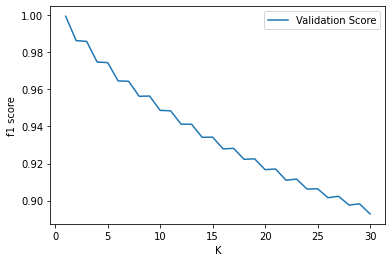

In [ ]:
KNN_k = np.arange(1,31)
plt.plot(KNN_k, KNN_train_score, label='Validation Score')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.legend()
plt.show()

# Output prediction on the testing set

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#2. Get the file
downloaded = drive.CreateFile({'id':'1hvWvyd9D5v1ZFrQ8dahYoD9ocv7CNnCz'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dataframe_test.csv') 
#3. Read file as panda dataframe
df_test = pd.read_csv("dataframe_test.csv")
df_test

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_type,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,urgency,hour
0,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509790,ASSIGN,2.100000e+18,121.630558,39.140900,121.629930,39.144603,796.0,1776,13.0
1,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509791,PICKUP,2.100000e+18,121.629930,39.144603,121.629604,39.150661,1048.0,697,13.0
2,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509792,DELIVERY,2.100000e+18,121.629604,39.150661,121.629930,39.144603,1019.0,1756,13.0
3,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509793,PICKUP,2.100000e+18,121.629930,39.144603,121.630544,39.152711,1198.0,676,13.0
4,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,4fdb588dc34ac31ce738a32696315b5d,5e65ed920db306852d16f1ec176011ed,509794,DELIVERY,2.100000e+18,121.630544,39.152711,121.631446,39.142762,1275.0,2336,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25463,125996858,5,2.100000e+18,121.447895,39.210704,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d0674c5fd609d26c9164e98bd4c3dc29,86ba4e4a1dcc00e61b1d82ea394e4533,535067,DELIVERY,2.100000e+18,121.457034,39.217461,121.453294,39.214381,703.0,3872,19.0
25464,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535068,ASSIGN,2.100000e+18,121.453580,39.205943,121.450119,39.209546,1297.0,2043,19.0
25465,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535069,PICKUP,2.100000e+18,121.450119,39.209546,121.450644,39.207601,233.0,1204,19.0
25466,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,86e50587e1ba446bc427c687f8593606,2626cd2412b5a56fe7665ee8aeb86f98,535070,DELIVERY,2.100000e+18,121.450644,39.207601,121.452471,39.209303,720.0,2948,19.0


In [ ]:
df_test = pd.read_csv("dataframe_test.csv")
df_test = pd.get_dummies(df_test,columns=['source_type'],drop_first = True)
df_test['bad_weather'] = np.array(df_test['weather_grade'] != 'Normal Weather').astype(int)
df_test

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,urgency,hour,source_type_ASSIGN,source_type_DELIVERY,source_type_PICKUP,bad_weather
0,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509790,2.100000e+18,121.630558,39.140900,121.629930,39.144603,796.0,1776,13.0,1,0,0,0
1,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509791,2.100000e+18,121.629930,39.144603,121.629604,39.150661,1048.0,697,13.0,0,0,1,0
2,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509792,2.100000e+18,121.629604,39.150661,121.629930,39.144603,1019.0,1756,13.0,0,1,0,0
3,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509793,2.100000e+18,121.629930,39.144603,121.630544,39.152711,1198.0,676,13.0,0,0,1,0
4,10007871,2,2.100000e+18,121.630558,39.140900,20200228,2.020000e+16,3,5.535851,11,Normal Weather,4fdb588dc34ac31ce738a32696315b5d,5e65ed920db306852d16f1ec176011ed,509794,2.100000e+18,121.630544,39.152711,121.631446,39.142762,1275.0,2336,14.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25463,125996858,5,2.100000e+18,121.447895,39.210704,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d0674c5fd609d26c9164e98bd4c3dc29,86ba4e4a1dcc00e61b1d82ea394e4533,535067,2.100000e+18,121.457034,39.217461,121.453294,39.214381,703.0,3872,19.0,0,1,0,0
25464,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535068,2.100000e+18,121.453580,39.205943,121.450119,39.209546,1297.0,2043,19.0,1,0,0,0
25465,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,d61d1ce18b53a55ed8729889ad16426a,cf304117a4b0eb083d47e55111bd4624,535069,2.100000e+18,121.450119,39.209546,121.450644,39.207601,233.0,1204,19.0,0,0,1,0
25466,125996858,6,2.100000e+18,121.453580,39.205943,20200228,2.020000e+17,3,5.681500,11,Normal Weather,86e50587e1ba446bc427c687f8593606,2626cd2412b5a56fe7665ee8aeb86f98,535070,2.100000e+18,121.450644,39.207601,121.452471,39.209303,720.0,2948,19.0,0,1,0,0


In [ ]:
preselect = ['target_lng', 'target_lat']
X_test = np.array(df_test[preselect]).reshape([df_test.shape[0],len(preselect)])
KNN = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors = 1))
KNN.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
y_pred_test = KNN.predict(X_test)
output = pd.DataFrame(y_pred_test)
output

,0
0,0
1,1
2,0
3,1
4,0
...,...
25463,1
25464,0
25465,1
25466,0


# Other attempts

In [ ]:
# subsample
df_train_sub = df_train.sample(n=50000,random_state=0)
df_train_sub

After testing ten different random state, the results are very similar, which indicates that the subsample is reasonable.

## Decision Tree Classification

In [ ]:
# All interpretable features
preselect = ['level','speed', 'max_load', 'source_lng', 'source_lat', 'target_lng','target_lat', 'grid_distance', 'urgency', 'hour', 'bad_weather']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['delivery'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
param = {'max_depth':np.arange(1,11),'min_samples_leaf':np.array(list(map(lambda x: int(x), np.logspace(0,3,4)))),'ccp_alpha':np.logspace(-5,1,10)}
Tree = DecisionTreeClassifier(random_state=0)
gridCV1 = GridSearchCV(Tree, param,scoring='f1',cv=5).fit(X_train,y_train)
print("Best parameter:",gridCV1.best_params_)
print("Corresponding score:",gridCV1.best_score_)

Best parameter: {'ccp_alpha': 0.001, 'max_depth': 6, 'min_samples_leaf': 1}
Corresponding score: 0.7288527297429972


In [ ]:
Tree_best = DecisionTreeClassifier(random_state=0,ccp_alpha = gridCV1.best_params_['ccp_alpha'],max_depth=gridCV1.best_params_['max_depth'],min_samples_leaf=gridCV1.best_params_['min_samples_leaf'])
Tree_best.fit(X_train,y_train)
y_pred_val = Tree_best.predict(X_val)
Tree_f1_val = f1_score(y_val, y_pred_val)
print(Tree_f1_val)

0.7241491085899514


In [ ]:
coeff = pd.DataFrame(preselect,Tree_best.feature_importances_)
coeff

,0
0.000000,level
0.000000,speed
0.000000,max_load
0.000000,source_lng
0.000000,source_lat
0.000000,target_lng
0.009837,target_lat
0.501503,grid_distance
0.482601,urgency
0.006060,hour


In [ ]:
# with selected features
preselect = ['target_lng','target_lat', 'grid_distance', 'urgency', 'hour']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['delivery'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)
param = {'ccp_alpha':np.logspace(-5,1,50)}
Tree = DecisionTreeClassifier(random_state=0)
gridCV2 = GridSearchCV(Tree, param,scoring='f1',cv=5).fit(X_train,y_train)
print("Best parameter:",gridCV2.best_params_)
print("Corresponding score:",gridCV2.best_score_)

Best parameter: {'ccp_alpha': 0.0006866488450042998}
Corresponding score: 0.7321760022514925


In [ ]:
Tree_best = DecisionTreeClassifier(random_state=0,ccp_alpha = gridCV2.best_params_['ccp_alpha'])
Tree_best.fit(X_train,y_train)
y_pred_val = Tree_best.predict(X_val)
Tree_f1_val = f1_score(y_val, y_pred_val)
print(Tree_f1_val)

0.722366710013004


In [ ]:
coeff = pd.DataFrame(preselect,Tree_best.feature_importances_)
coeff

,0
0.005720,target_lng
0.014234,target_lat
0.496272,grid_distance
0.477844,urgency
0.005930,hour


### Best decision tree model

In [ ]:
preselect = ['target_lng','target_lat', 'grid_distance', 'urgency', 'hour']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['delivery'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)
Tree_best = DecisionTreeClassifier(random_state=0,ccp_alpha = gridCV2.best_params_['ccp_alpha'])
Tree_best.fit(X_train,y_train)
y_pred_val = Tree_best.predict(X_val)
Tree_f1_val = f1_score(y_val, y_pred_val)
print(Tree_f1_val)

0.7169687201920864


## Logit Regression

### Lasso

In [ ]:
preselect = ['level','speed', 'max_load', 'source_lng', 'source_lat', 'target_lng','target_lat', 'grid_distance', 'urgency', 'hour', 'bad_weather']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['delivery'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
param_test = {'C':np.logspace(-5, 2)}
LogitR_l1 = LogitReg(penalty='l1',solver='liblinear',max_iter=10000)
gridCV3 = GridSearchCV(LogitR_l1 , param_grid = param_test, cv=5 ,scoring='f1')
gridCV3.fit(X_train,y_train)
print('The best associated parameter is:',gridCV3.best_params_)
print('The best cross-validated f1 score is:',gridCV3.best_score_)

The best associated parameter is: {'C': 2.6826957952797274e-05}
The best cross-validated f1 score is: 0.7025628272425734


In [ ]:
LogitR_l1_best = LogitReg(penalty='l1',solver='liblinear',max_iter=10000, C = gridCV3.best_params_['C'] )
LogitR_l1_best.fit(X_train,y_train)
y_pred_val = LogitR_l1_best.predict(X_val)
f1_score_val = f1_score(y_val, y_pred_val)
print(f1_score_val)

0.6767148569670871


In [ ]:
df_coeff = pd.DataFrame({
    'Feature': preselect, 
    'Coefficient': np.array(LogitR_l1_best.coef_).reshape(11)
})
df_coeff

,Feature,Coefficient
0,level,0.000000
1,speed,0.000000
2,max_load,0.000000
3,source_lng,-0.002222
4,source_lat,0.000000
5,target_lng,-0.000497
6,target_lat,0.000000
7,grid_distance,0.000577
8,urgency,-0.000034
9,hour,0.000000


### Ridge

In [ ]:
preselect = ['level','speed', 'max_load', 'source_lng', 'source_lat', 'target_lng','target_lat', 'grid_distance', 'urgency', 'hour', 'bad_weather']
X = np.array(df_train_sub[preselect]).reshape([df_train_sub.shape[0],len(preselect)])
y = np.array(df_train_sub['delivery'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
param_test = {'C':np.logspace(-5, 2)}
LogitR_l2 = LogitReg(penalty='l2',max_iter=10000)
gridCV4 = GridSearchCV(LogitR_l2 , param_grid = param_test, cv=5 ,scoring='f1')
gridCV4.fit(X_train,y_train)
print('The best associated parameter is:',gridCV4.best_params_)
print('The best cross-validated f1 score is:',gridCV4.best_score_)

The best associated parameter is: {'C': 0.00013894954943731373}
The best cross-validated f1 score is: 0.6439220818907425


In [ ]:
LogitR_l2_best = LogitReg(penalty='l2',max_iter=10000, C = gridCV4.best_params_['C'] )
LogitR_l2_best.fit(X_train,y_train)
y_pred_val = LogitR_l2_best.predict(X_val)
f1_score_val = f1_score(y_val, y_pred_val)
print(f1_score_val)

0.6301369863013698


### Best logit model

In [ ]:
preselect = ['level','speed', 'max_load', 'source_lng', 'source_lat', 'target_lng','target_lat', 'grid_distance', 'urgency', 'hour', 'bad_weather']
X = np.array(df_train[preselect]).reshape([df_train.shape[0],len(preselect)])
y = np.array(df_train['delivery'])
X_train, X_val, y_train, y_val = tr_te_split(X, y, test_size=0.3,random_state=0)

In [ ]:
LogitR_l1_best = LogitReg(penalty='l1',solver='liblinear',max_iter=10000, C = gridCV3.best_params_['C'] )
LogitR_l1_best.fit(X_train,y_train)
y_pred_val = LogitR_l1_best.predict(X_val)
f1_score_val = f1_score(y_val, y_pred_val)
print(f1_score_val)

0.6278850484125196


## KNN with PCA

In [ ]:
# 2 components
PCA_train_score2 = []
PCA_val_score2 =[]

In [ ]:
for i in range(1,11,1):
  KNN = make_pipeline(StandardScaler(),PCA(n_components=2),KNeighborsClassifier(n_neighbors = i))
  KNN.fit(X_train, y_train)
  print('k =',i)

  y_pred_train = KNN.predict(X_train)
  f1_score_train = f1_score(y_train, y_pred_train)
  print('training f1:',f1_score_train)
    
  y_pred_val = KNN.predict(X_val)
  f1_score_val = f1_score(y_val, y_pred_val)
  print('testing f1:',f1_score_val)
    
  PCA_train_score2.append(f1_score_train)
  PCA_val_score2.append(f1_score_val)

k = 1
training f1: 1.0
testing f1: 0.5264405507378069
k = 2
training f1: 0.6836197140002729
testing f1: 0.3686940857561035
k = 3
training f1: 0.7611965523069124
testing f1: 0.5283805352926434
k = 4
training f1: 0.6385637763528447
testing f1: 0.42534507396437893
k = 5
training f1: 0.7017684366072864
testing f1: 0.5300592270767444
k = 6
training f1: 0.6184540945453113
testing f1: 0.45199910860427406
k = 7
training f1: 0.6723131005919163
testing f1: 0.5325428160198598
k = 8
training f1: 0.6047893994454244
testing f1: 0.4672591101328866
k = 9
training f1: 0.6539559439492174
testing f1: 0.5331552181360069
k = 10
training f1: 0.5962944302377535
testing f1: 0.4742665312988639


In [ ]:
# 5 components
PCA_train_score5 = []
PCA_val_score5 =[]

In [ ]:
for i in range(1,11,1):
  KNN = make_pipeline(StandardScaler(),PCA(n_components=5),KNeighborsClassifier(n_neighbors = i))
  KNN.fit(X_train, y_train)
  print('k =',i)

  y_pred_train = KNN.predict(X_train)
  f1_score_train = f1_score(y_train, y_pred_train)
  print('training f1:',f1_score_train)
    
  y_pred_val = KNN.predict(X_val)
  f1_score_val = f1_score(y_val, y_pred_val)
  print('testing f1:',f1_score_val)
    
  PCA_train_score2.append(f1_score_train)
  PCA_val_score2.append(f1_score_val)

k = 1
training f1: 1.0
testing f1: 0.5264405507378069
k = 2
training f1: 0.6836197140002729
testing f1: 0.3686940857561035
k = 3
training f1: 0.7611965523069124
testing f1: 0.5283805352926434
k = 4
training f1: 0.6385637763528447
testing f1: 0.42534507396437893
k = 5
training f1: 0.7017684366072864
testing f1: 0.5300592270767444
k = 6
training f1: 0.6184540945453113
testing f1: 0.45199910860427406
k = 7
training f1: 0.6723131005919163
testing f1: 0.5325428160198598
k = 8
training f1: 0.6047893994454244
testing f1: 0.4672591101328866
k = 9
training f1: 0.6539559439492174
testing f1: 0.5331552181360069
k = 10
training f1: 0.5962944302377535
testing f1: 0.4742665312988639
